# XGBoost Multi-Output Regression (cleaned version)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle

In [2]:
np.random.seed(42)
hours = pd.date_range("2024-01-01", periods=720, freq="H")

C:\Users\wajee\AppData\Local\Temp\ipykernel_144364\899848321.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range("2024-01-01", periods=720, freq="H")


In [3]:
# Weather data
weather_df = pd.DataFrame({
    "datetime": hours,
    "temperature_2m": 5 + 10 * np.sin(np.linspace(0, 6 * np.pi, 720)) + np.random.normal(0, 1, 720),
    "relative_humidity_2m": np.clip(50 + 20 * np.sin(np.linspace(0, 3 * np.pi, 720)) + np.random.normal(0, 5, 720), 20, 100),
    "wind_speed_10m": np.abs(np.random.normal(10, 3, 720)),
    "precipitation": np.abs(np.random.normal(0.2, 0.1, 720))
})
print(f"✅ Weather generated: {weather_df.shape}")

✅ Weather generated: (720, 5)


In [4]:
# Indoor & energy data
indoor_df = pd.DataFrame({
    "datetime": hours,
    "room_temperature": 22 + 2 * np.sin(np.linspace(0, 4 * np.pi, 720)) + np.random.normal(0, 0.5, 720),
    "room_humidity": np.clip(45 + 10 * np.cos(np.linspace(0, 2 * np.pi, 720)) + np.random.normal(0, 2, 720), 30, 70),
    "HVAC_temperature": 21 + 1.5 * np.sin(np.linspace(0, 2 * np.pi, 720)) + np.random.normal(0, 0.3, 720),
    "synthetic_energy": np.clip(0.5 + 0.01 * (25 - weather_df["temperature_2m"]) + np.random.normal(0, 0.05, 720), 0, None)
})
print(f"✅ Indoor generated: {indoor_df.shape}")

✅ Indoor generated: (720, 5)


In [5]:
# 2. Merge datasets

In [6]:
merged = pd.merge(weather_df, indoor_df, on="datetime", how="inner")

In [7]:
# ---------------------------
# 3. Feature engineering
# ---------------------------
merged["hour"] = merged["datetime"].dt.hour
merged["day_of_week"] = merged["datetime"].dt.dayofweek
merged["month"] = merged["datetime"].dt.month
merged["is_weekend"] = merged["day_of_week"].isin([5, 6]).astype(int)


In [8]:
# Lag and rolling features
for lag in [1, 2, 3, 6, 24]:
    merged[f"room_temp_lag{lag}"] = merged["room_temperature"].shift(lag)
    merged[f"energy_lag{lag}"] = merged["synthetic_energy"].shift(lag)

merged["room_temp_roll3"] = merged["room_temperature"].rolling(window=3).mean()
merged["energy_roll3"] = merged["synthetic_energy"].rolling(window=3).mean()
merged.dropna(inplace=True)

print(f"✅ Merged dataset: {merged.shape}")

✅ Merged dataset: (696, 25)


In [9]:
# ---------------------------
# 4. Select features & targets
# ---------------------------
target_cols = ["room_temperature", "synthetic_energy"]

# ✅ Simplified feature set
feature_cols = [
    "temperature_2m", "relative_humidity_2m",  # weather
    "room_temperature", "room_humidity", "HVAC_temperature",  # indoor
    "hour", "is_weekend",                     # time
    "energy_lag1", "energy_lag2", "energy_roll3", "room_temp_roll3"  # essential dynamics
]

X = merged[feature_cols]
y = merged[target_cols]

print("Feature matrix shape:", X.shape)
print("Target matrix shape:", y.shape)

Feature matrix shape: (696, 11)
Target matrix shape: (696, 2)


In [10]:
# ---------------------------
# 5. Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# ---------------------------
# 6. Train XGBoost model
# ---------------------------
model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )
)
model.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None


In [12]:
# ---------------------------
# 7. Evaluate performance
# ---------------------------
y_pred = model.predict(X_test)
print("\nEvaluation on test set:")
for i, target in enumerate(target_cols):
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f" - {target}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")



Evaluation on test set:
 - room_temperature: RMSE = 0.0841, R2 = 0.9895
 - synthetic_energy: RMSE = 0.0281, R2 = 0.8187


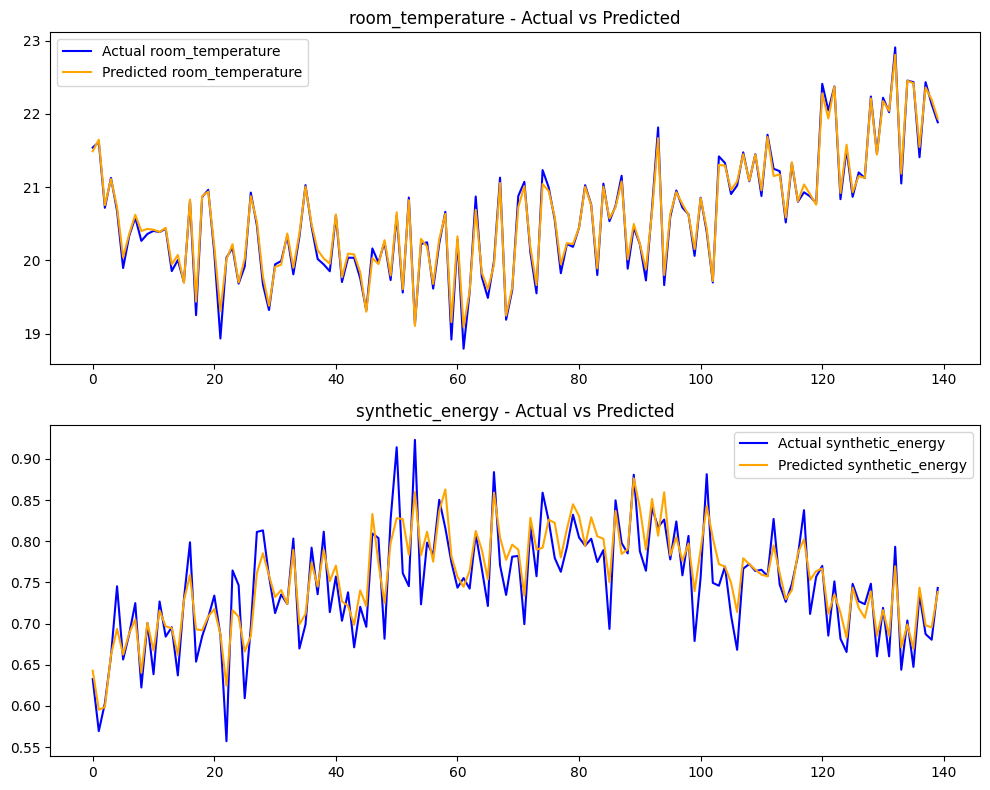

In [13]:
# ---------------------------
# 8. Plot actual vs predicted
# ---------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for i, target in enumerate(target_cols):
    axes[i].plot(y_test.iloc[:, i].values, label=f"Actual {target}", color="blue")
    axes[i].plot(y_pred[:, i], label=f"Predicted {target}", color="orange")
    axes[i].set_title(f"{target} - Actual vs Predicted")
    axes[i].legend()
plt.tight_layout()
plt.show()

In [14]:
# ---------------------------
# 9. Save model + features
# ---------------------------
with open("multioutput_xgb_model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("feature_cols.pkl", "wb") as f:
    pickle.dump(feature_cols, f)

print("\n✅ Model saved to 'multioutput_xgb_model.pkl'")
print("✅ Feature list saved to 'feature_cols.pkl'")


✅ Model saved to 'multioutput_xgb_model.pkl'
✅ Feature list saved to 'feature_cols.pkl'
